In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm

In [28]:
class PolynomialRegression():
    def __init__(self, degree=None, learning_rate=0.001, epochs=100000) -> None:
        if degree <= 0:
            raise ValueError("Degree must be a positive number greater")
        self.degree = degree if degree else 1
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.theta = None
        self.costs = []
    
    def _extend_polynomial(self, X):
        return np.hstack([X**i for i in range(1, self.degree + 1)])
    
    def _normalize(self, X):
        return (X - self.minX) / (self.maxX - self.minX)

    def fit(self, X, y, subplots=False):
        sorting_indices = np.argsort(X, axis=0)
        X = X[sorting_indices].reshape(-1,1)
        y = y[sorting_indices].reshape(-1,1)
        self.X = X
        X = self._extend_polynomial(X)
        self.minX = np.min(X, axis=0)
        self.maxX = np.max(X, axis=0)
        X = self._normalize(X)

        X = np.hstack((np.ones((X.shape[0], 1)), X))
        
        self.theta = np.zeros((X.shape[1], 1))
        m, n = X.shape
        prev_cost = float('inf')
        self.costs = []

        for epoch in range(self.epochs):
            y_pred = np.dot(X, self.theta)
            error = y_pred - y
            cost = (1/(2*m) * np.sum(np.square(error)))
            d_theta = (1/m) * np.dot(X.T, error)
            self.theta = self.theta - self.learning_rate * d_theta
            self.costs.append(cost)
            if abs(prev_cost - cost) < 0.0001:
                print(f'Converged at epoch {epoch}')
                break
            prev_cost = cost
            if subplots:
                plt.scatter(self.X, y, c="red")
                plt.plot(self.X, y_pred)
                plt.pause(0.0001)
                plt.clf()
        
        #plt.scatter(self.X, y, c="red")
        #plt.plot(self.X, y_pred)
        #plt.show()

    def plot_error_history(self):
        plt.plot(np.arange(1,len(self.costs) + 1), self.costs)
        plt.xlabel('Number of epochs')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE vs Epochs')
        plt.show()
    
    def predict(self, X):
        X = self._extend_polynomial(X)
        X = self._normalize(X)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        y_pred = np.dot(X, self.theta)
        return y_pred

def test_polynomials():
    X = np.arange(1,11).reshape(-1,1)
    y = np.array([1,4,31,69,120,223,336,515,722,1000]).reshape(-1,1)
    costs = []
    for i in range(1,11):
        print(f"MSE for polynomial of degree {i}.")
        model = PolynomialRegression(degree=i)
        model.fit(X,y)
        print(model.costs[len(model.costs) - 1])
        costs.append(model.costs[len(model.costs) - 1])
        #model.plot_error_history()
    plt.plot(np.arange(1,len(costs) + 1), costs)
    plt.xlabel('Degree of polynomial')
    plt.ylabel('Cost (MSE)')
    plt.title('Final cost of regressor vs Degree of Polynomial')
    plt.show()

def onehotencode(X, column):
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    from sklearn.compose import make_column_transformer
    label_encoder_X = LabelEncoder()
    X[:,column] = label_encoder_X.fit_transform(X[:,column])
    onehotencoder = make_column_transformer((OneHotEncoder(), [column]), remainder = 'passthrough')
    X = onehotencoder.fit_transform(X)
    return X[:,1:]

import statsmodels.api as sm

def backwards_elimination(X, y, SL):
    X = np.append(arr=np.ones((X.shape[0], 1)).astype(int), values=X, axis=1)
    arr = [ i for i in range(len(X[0]))]
    endwhile = False
    while not endwhile:
        X_opt = X[:,arr]
        regression_OLS = sm.OLS(endog=y, exog=X_opt.tolist()).fit()
        values = regression_OLS.pvalues
        max_p_value = max(values)
        if max_p_value > SL:
            arr.pop(values.tolist().index(max_p_value))
        else:
            endwhile = True
    #print(regression_OLS.summary())
    print("Best variables are:", arr[1:])
    return X_opt[:,1:]

def preprocess_dataframe(df):
    def ohe(df, column):
        onehot = pd.get_dummies(df[column], dtype=int)
        df.drop([column], axis=1, inplace=True)
        df = pd.concat([df, onehot], axis=1)
        return df.iloc[:,:-1]
    y = (df.iloc[:,-1].values).reshape(-1,1)
    #df.drop(['Profit'], axis = 1, inplace=True)
    df = ohe(df, 'State') # OneHotEncode whatever column you want
    profit = df.pop('Profit')
    df['Profit'] = profit
    X = df.iloc[:,:].values
    return df

def print_corr(df):
    matriz = df.corr() # -1 (existe una relación fuerte)  0   1 (existe relación fuerte)
    plt.matshow(matriz, cmap="coolwarm", vmin=-1, vmax=1)
    plt.xticks(range(len(matriz)), df.columns, rotation=45)
    plt.yticks(range(len(matriz)), df.columns)

    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j, round(matriz.iloc[i, j], 2),
                    ha="center", va="center")
    plt.colorbar()
    plt.show()

def my_train_test_split(X,y, train_size=0.7):
    sep = int(len(X) * train_size)
    X_train, X_test = X[:sep], X[sep:]
    y_train, y_test = y[:sep], y[sep:]
    return X_train, X_test, y_train, y_test

def r2_score(y_true, y_pred):
    mean_y_true = np.mean(y_true)
    ssTOT = np.sum((y_true - mean_y_true) ** 2)
    ssRES = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ssRES / ssTOT)
    return r2

def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

def plot_r2_bars(a, b):
    etiquetas = ['70% vs 30%', '50% vs 50%', '30% vs 70%']
    width = 0.3
    x = np.arange(len(etiquetas))
    font_size = 10

    plt.bar(x - width/2, a, width=width, label='Proposed Model')
    plt.bar(x + width/2, b, width=width, label='Sklearn Model')

    for xi, ai, bi in zip(x, a, b):
        plt.text(xi - width/2, ai, '%.4f' % ai, ha='center', va='bottom', fontsize=font_size)
        plt.text(xi + width/2, bi, '%.4f' % bi, ha='center', va='bottom', fontsize=font_size)

    plt.xticks(x, etiquetas)
    plt.legend(loc='lower left')
    plt.xlabel("Train size vs Test size")
    plt.ylabel("R2 Score")
    plt.title("Comparación de R2 Scores (Proposed model vs Sklearn model)" )
    plt.show()

def plot_mse_bars(a, b):
    etiquetas = ['70% vs 30%', '50% vs 50%', '30% vs 70%']
    width = 0.3
    x = np.arange(len(etiquetas))
    font_size = 10

    plt.bar(x - width/2, a, width=width, label='Proposed Model')
    plt.bar(x + width/2, b, width=width, label='Sklearn Model')

    for xi, ai, bi in zip(x, a, b):
        ai_label = '{:.1e}'.format(ai)
        bi_label = '{:.1e}'.format(bi)
        plt.text(xi - width/2, ai, ai_label, ha='center', va='bottom', fontsize=font_size)
        plt.text(xi + width/2, bi, bi_label, ha='center', va='bottom', fontsize=font_size)

    plt.xticks(x, etiquetas)
    plt.legend(loc='lower left')
    plt.xlabel("Train size vs Test size")
    plt.ylabel("MSE Score")
    plt.title("Comparación de MSE (Proposed model vs Sklearn model)" )
    plt.show()

In [26]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures

def experiment_with_train_size(X, y):
    train_sizes = [0.7, 0.5, 0.3]
    r2_proposed_model = []
    r2_sklearn_model = []
    mse_proposed_model = []
    mse_sklearn_model = []
    for train_size in train_sizes:
        X_train, X_test, y_train, y_test = my_train_test_split(X, y, train_size=train_size)
        
       # Proposed model
        model = PolynomialRegression(degree=2, learning_rate=0.01, epochs=50000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        model_r2 = r2_score(y_test, y_pred)
        model_mse = mean_squared_error(y_test, y_pred)

        # Sklearn Model

        poly_reg = PolynomialFeatures(degree=2)
        X_poly = poly_reg.fit_transform(X_train)
        sklearn_model = LR()
        sklearn_model.fit(X_poly, y_train)
        y_pred = sklearn_model.predict(poly_reg.fit_transform(X_test))

        sklearn_r2 = r2_score(y_test, y_pred)
        sklearn_mse = mean_squared_error(y_test, y_pred)
        
        r2_proposed_model.append(model_r2)
        r2_sklearn_model.append(sklearn_r2)
        mse_proposed_model.append(model_mse)
        mse_sklearn_model.append(sklearn_mse)
    
    print("r2_proposed_model")
    print(r2_proposed_model)
    print("r2_sklearn_model")
    print(r2_sklearn_model)
    
    print("mse_proposed_model")
    print(mse_proposed_model)
    print("mse_sklearn_model")
    print(mse_sklearn_model)
    
    plot_r2_bars(r2_proposed_model, r2_sklearn_model)
    plot_mse_bars(mse_proposed_model, mse_sklearn_model)

In [10]:
df = pd.read_csv("datasets/50_Startups.csv")

df = df[(df != 0).all(1)]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df = preprocess_dataframe(df)

cities = df[['California', 'Florida']]
df.drop(['California', 'Florida'], axis=1, inplace=True)
df = pd.concat([cities, df], axis=1)

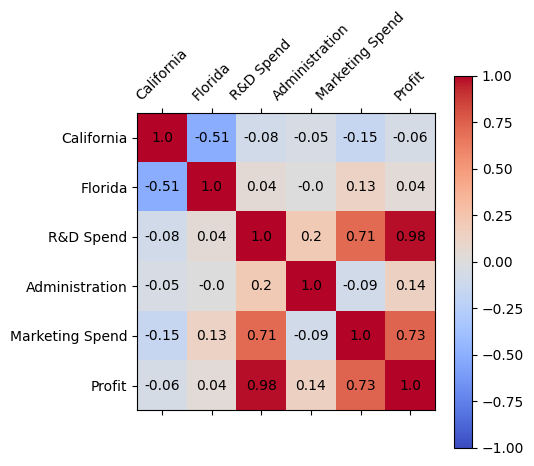

In [11]:
print_corr(df)

In [12]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

X_opt = backwards_elimination(X, y, 0.05)
y = y.reshape(-1,1)

Best variables are: [3]


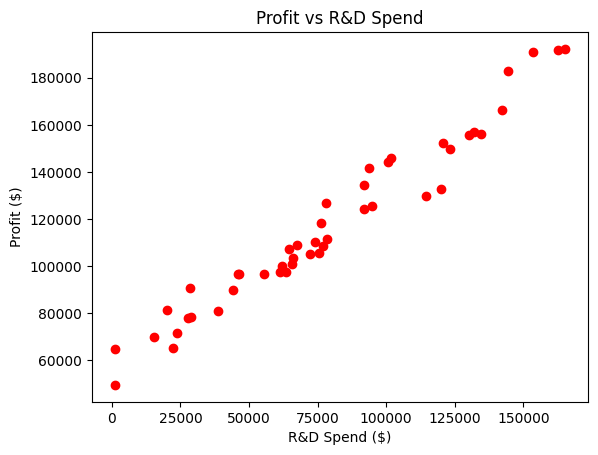

In [16]:
plt.scatter(X_opt, y, c="red")
plt.xlabel('R&D Spend ($)')
plt.ylabel('Profit ($)')
plt.title("Profit vs R&D Spend")
plt.show()

27894261.056121785
26775464.953843877
28447565.53038367
27975035.490785453
27385156.228061046
27245194.639641117
27417673.87583886
27701837.29268558
27979343.24961456


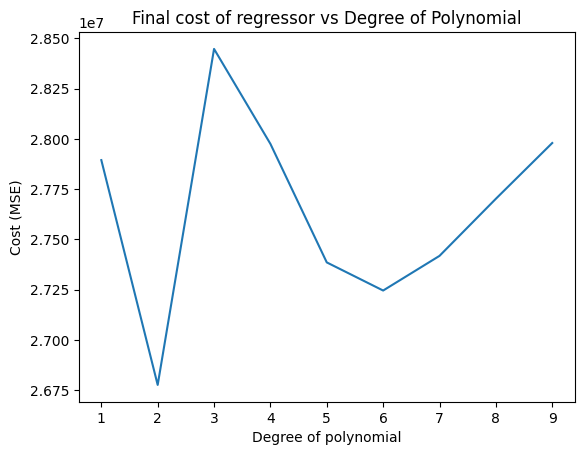

In [17]:
costs = []
for i in range(1,10):
    model = PolynomialRegression(degree=i)
    model.fit(X_opt, y, subplots=False)
    print(model.costs[-1])
    costs.append(model.costs[len(model.costs) - 1])
plt.plot(np.arange(1,len(costs) + 1), costs)
plt.xlabel('Degree of polynomial')
plt.ylabel('Cost (MSE)')
plt.title('Final cost of regressor vs Degree of Polynomial')
plt.show()

r2_proposed_model
[0.9485341787485513, 0.9676814408866813, 0.9538034835691298]
r2_sklearn_model
[0.9499539942491588, 0.9679649678603471, 0.954334017903002]
mse_proposed_model
[64058953.242857836, 47748551.99293786, 56423056.617177]
mse_sklearn_model
[62291724.18568351, 47329659.47993887, 55775077.698631816]


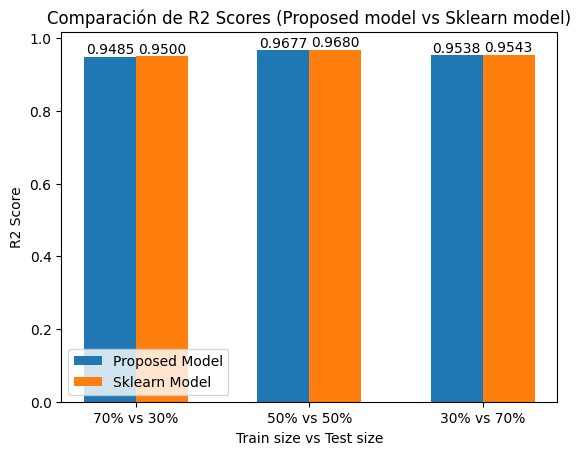

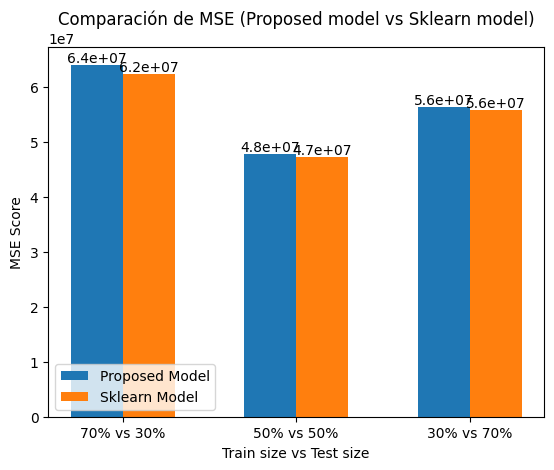

In [29]:
experiment_with_train_size(X_opt, y)